<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/DeepLearning/1D_CNN_to_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright
<pre>
Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen
tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérejük az alábbi szerzőt értesíteni.

2023 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu), Zainkó Csaba
</pre>

Jelen notebook egy példakódot mutat be egy dimenziós konvolúció alapú szekvenciális adat modellezésre. A példakód elsődlegesen az 1D konvolúcióra koncentrál, az általános megfontolások (standardizálás, min-max skálázás, early stopping, regularizáció, stb.) itt nem szerepelnek, de éles feladatokban szükségszerűek.

In [28]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

Az egy dimenziós konvolúciós rétegek létrehozása.

In [29]:
def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):
    model = Sequential()
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', input_shape=(window_size, nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

LSTM

In [30]:
# Ez tippre rossz amúgy
def make_lstm(window_size, nb_input_series=1, nb_outputs=1, nb_filter=32):
    model = Sequential()
    model.add(LSTM(nb_filter, input_shape=(window_size, nb_input_series)))
    model.add(Dense(nb_outputs, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

Az idősor adatokból az egy dimenziós konvolúció számára megfelelő formátum létrehozása.

In [31]:
def make_timeseries_instances(timeseries, window_size):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {} ".format(window_size,timeseries.shape[0])
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    Y = timeseries[window_size:]
    return X, Y

A hálózat létrehozását, adatok formázását és tanítását az alábbi függvény végzi, és visszatér a predikcióval és az eredeti értékekkel:

In [32]:
def evaluate_timeseries(timeseries, window_size, valid_split=0.15, test_split=0.15):
    filter_length = 5
    nb_filter = 32
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # 1D vektor -> 2D matrix
    nb_samples, nb_series = timeseries.shape
    # model = make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
    model = make_lstm(window_size=window_size, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
    model.summary()
    X, Y = make_timeseries_instances(timeseries, window_size)

    valid_size = int(nb_samples*(1-test_split-valid_split))
    test_size = int(nb_samples*(1-test_split))
    X_train, Y_train = X[:valid_size], Y[:valid_size]
    X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
    X_test, Y_test   = X[test_size:], Y[test_size:]

    model.fit(X_train, Y_train, epochs=50, batch_size=16, validation_data=(X_valid, Y_valid), verbose=2)

    preds   = model.predict(X_test)

    return Y_test, preds


Minta adatok létrehozása és megjelenítése:

In [33]:
# adatok elkészítése
lp 	= np.linspace(-10*np.pi,10*np.pi,1000)
X 	= np.sin(lp)*3+np.cos(lp*2)+np.sin(np.pi/2+lp*4)*1.5+np.log(np.abs(lp))

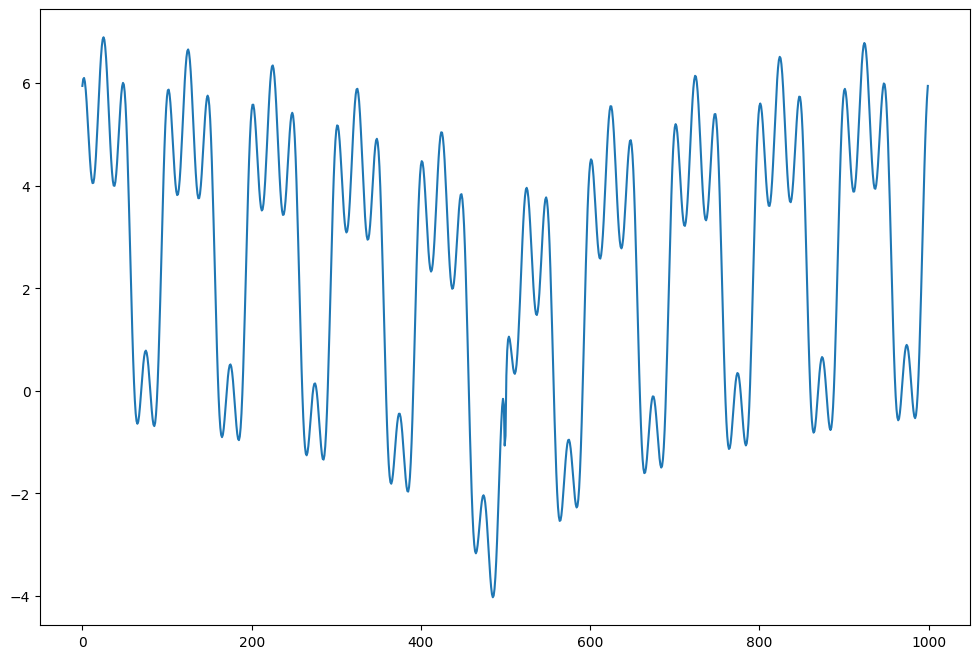

In [34]:
plt.figure(figsize=(12,8))
plt.plot(X)

Tanítás elindítása:

In [35]:
window_size = 20
targets, preds = evaluate_timeseries(X, window_size)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
44/44 - 1s - 32ms/step - loss: 3.6288 - mae: 1.5319 - val_loss: 1.6947 - val_mae: 1.0689
Epoch 2/50
44/44 - 0s - 5ms/step - loss: 1.1047 - mae: 0.8565 - val_loss: 0.5815 - val_mae: 0.6543
Epoch 3/50
44/44 - 0s - 7ms/step - loss: 0.5230 - mae: 0.5664 - val_loss: 0.2035 - val_mae: 0.3823
Epoch 4/50
44/44 - 0s - 7ms/step - loss: 0.3140 - mae: 0.3959 - val_loss: 0.1108 - val_mae: 0.2584
Epoch 5/50
44/44 - 0s - 6ms/step - loss: 0.2299 - mae: 0.3242 - val_loss: 0.0774 - val_mae: 0.2097
Epoch 6/50
44/44 - 0s - 5ms/step - loss: 0.1782 - mae: 0.2846 - val_loss: 0.0546 - val_mae: 0.1776
Epoch 7/50
44/44 - 0s - 5ms/step - loss: 0.1378 - mae: 0.2470 - val_loss: 0.0455 - val_mae: 0.1659
Epoch 8/50
44/44 - 0s - 5ms/step - loss: 0.1089 - mae: 0.2200 - val_loss: 0.0317 - val_mae: 0.1398
Epoch 9/50
44/44 - 0s - 7ms/step - loss: 0.0884 - mae: 0.2000 - val_loss: 0.0289 - val_mae: 0.1249
Epoch 10/50
44/44 - 0s - 7ms/step - loss: 0.0745 - mae: 0.1794 - val_loss: 0.0216 - val_mae: 0.1178
Epoch 11

Végül megjelenítjük a predikciót és az eredeti értékeket.

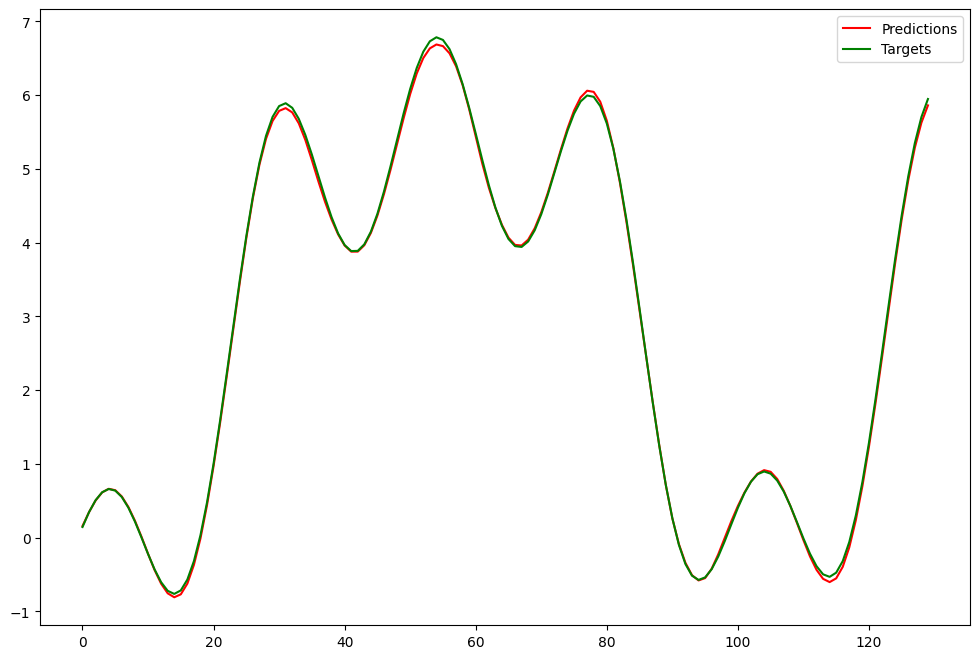

In [36]:
plt.figure(figsize=(12,8))
plt.plot(preds, color='r', label="Predictions")
plt.plot(targets, color='g', label="Targets")
plt.legend()